In [ ]:
!kaggle datasets download williamhyun/amazon-bin-image-dataset-536434-images-224x224
!rm -rf bin-images-224x224
!unzip amazon-bin-image-dataset-536434-images-224x224.zip > /dev/null

 99% 3.47G/3.50G [00:14<00:00, 342MB/s]
100% 3.50G/3.50G [00:14<00:00, 260MB/s]


# Install required packages

In [ ]:
!pip3 install -U timm torchvision # > /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load medatadata

In [ ]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("metadata.db")
df = pd.read_sql_query("SELECT name, json_extract(metadata, '$.EXPECTED_QUANTITY') quantity FROM metadata", conn)
conn.close()
df

,name,quantity
0,00001.jpg,12
1,1.jpg,0
2,00002.jpg,17
3,2.jpg,0
4,00003.jpg,16
...,...,...
536429,535230.jpg,3
536430,535231.jpg,4
536431,535232.jpg,3
536432,535233.jpg,2


# Check class distribution

In [ ]:
df.describe()

,quantity
count,536434.000000
mean,5.107281
std,4.620148
min,0.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,209.000000


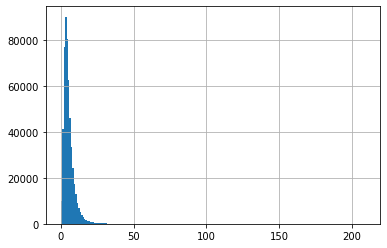

In [ ]:
df.quantity.hist(bins=210)

In [ ]:
df.quantile(.75)

quantity    6.0
Name: 0.75, dtype: float64

In [ ]:
df2 = df[df['quantity'] < 7]
df2.describe()

,quantity
count,408025.000000
mean,3.379290
std,1.580104
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


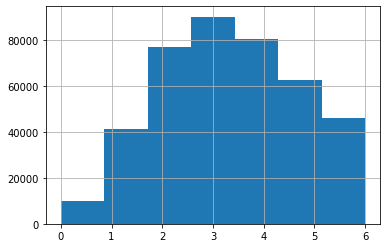

In [ ]:
df2.quantity.hist(bins=7)

In [ ]:
CLASS_WEIGHTS = df2.groupby(['quantity'])['quantity'].count().apply(lambda x: 1/x)
CLASS_WEIGHTS

quantity
0    0.000101
1    0.000024
2    0.000013
3    0.000011
4    0.000012
5    0.000016
6    0.000022
Name: quantity, dtype: float64

# Split train and test dataset

In [ ]:
import numpy as np
train_all, test_all = np.split(df2.sample(frac=1), [int(.9*len(df2))])

In [ ]:
test_all.describe()

,quantity
count,40803.000000
mean,3.376492
std,1.580358
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


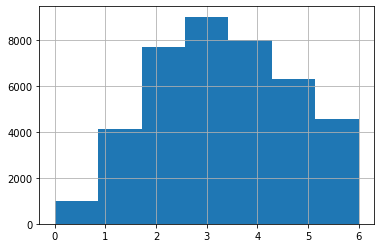

In [ ]:
test_all.quantity.hist(bins=7)

# Create loader function with WeightedRandomSampler

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class MyDataset(Dataset):
    def __init__(self, X, y, directory, transform):
        self.X = X
        self.y = y
        self.N = len(y)
        self.directory = directory
        self.transform = transform
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        image = self.transform(Image.open('{}{}'.format(self.directory, self.X.iloc[idx, 0])))
        return [image, self.y.iloc[idx]]

def loader(X, y, transforms):
    ds = MyDataset(X, y, 'bin-images-224x224/bin-images-224x224/', transforms)
    sample_weights = [0] * len(y)
    for idx, label in enumerate(y):
        sample_weights[idx] = CLASS_WEIGHTS[label]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights))
    return DataLoader(ds, batch_size=256, num_workers=6, sampler=sampler)

# Data Augumentation

In [ ]:
import torchvision
from torchvision import transforms as T

train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.1),
    T.RandomGrayscale(p=0.1),
    T.RandomAdjustSharpness(2, p=0.1),
    T.RandomAutocontrast(p=0.1),
    T.RandomApply([T.ColorJitter(0.5, 0.5, 0.5, 0.5)], p=0.1),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0, 0.02), scale=(0.95, 0.99))], p=0.1),
    T.RandomApply([T.RandomChoice([
        T.RandomRotation((90, 90)),
        T.RandomRotation((-90, -90)),
    ])], p=0.1),
    T.ToTensor(),
])

valid_transforms = T.Compose([
    T.ToTensor(),
])

# Model Design

In [ ]:
import timm
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def net(name, pretrained=True):
    model = timm.create_model(name, pretrained)
    for param in model.parameters():
        param.requires_grad = False

    layer = nn.Sequential(
        nn.Linear(model.get_classifier().in_features, 7, bias=False),
    )
    if name.startswith('resnet'):
        model.fc = layer
    else: # efficientnet
        model.classifier = layer
    return model

cuda


In [ ]:
import timm
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def net(name, pretrained=True):
    model = timm.create_model(name, pretrained)
    for param in model.parameters():
        param.requires_grad = False

    layer = nn.Sequential(
        nn.BatchNorm1d(model.get_classifier().in_features),
        nn.Linear(model.get_classifier().in_features, 512, bias=False),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(512, 7, bias=False))
    if name.startswith('resnet'):
        model.fc = layer
    else: # efficientnet
        model.classifier = layer
    return model

cuda


# Define validate and train functions

In [ ]:
import sys
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR

def validate(model, data_loader):
    model.eval()
    running_corrects=0
    for (inputs, labels) in tqdm(data_loader, 'Validate', file=sys.stdout):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        
    total_acc = 100.0 * running_corrects / len(data_loader.dataset)
    print("Average accuracy: %f" % total_acc)
    return total_acc

def train(model, train_loader, valid_loader, epochs, optimizer):
    # scheduler = LambdaLR(optimizer, lr_lambda=lambda e: 0.65 ** e)
    criterion = nn.CrossEntropyLoss()
    model.train()
    previous_accuracy = 0
    for e in range(1, epochs+1):
        train_loss = 0
        for (inputs, labels) in tqdm(train_loader, 'Epoch %s' % e, file=sys.stdout):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {e:3d}, Loss: {train_loss / len(train_loader)}')
        # scheduler.step()
    return model

# Baseline

In [ ]:
from torch.optim import Adam
from sklearn.model_selection import StratifiedKFold

name = 'efficientnet_b0'
EPOCHS = 5

# Split with the original dataframe ds2.length in order to test_all.length
train_baseline, valid_baseline = np.split(train_all, [int(.8*len(df2))])

X1 = train_baseline.drop('quantity', axis=1)
y1 = train_baseline.quantity
t = loader(X1, y1, T.ToTensor())

X2 = valid_baseline.drop('quantity', axis=1)
y2 = valid_baseline.quantity
v = loader(X2, y2, T.ToTensor())

model = net(name).to(device)
optimizer = Adam(model.get_classifier().parameters(), lr=1e-3, weight_decay=1e-4)
model = train(model, t, v, EPOCHS, optimizer)

Epoch 1: 100%|██████████| 1276/1276 [03:50<00:00,  5.53it/s]
Epoch   1, Loss: 1.4472633452624737
Epoch 2: 100%|██████████| 1276/1276 [03:51<00:00,  5.51it/s]
Epoch   2, Loss: 1.3839595676589536
Epoch 3: 100%|██████████| 1276/1276 [03:51<00:00,  5.51it/s]
Epoch   3, Loss: 1.3611664063878195
Epoch 4: 100%|██████████| 1276/1276 [03:51<00:00,  5.51it/s]
Epoch   4, Loss: 1.343955051095508
Epoch 5: 100%|██████████| 1276/1276 [03:50<00:00,  5.53it/s]
Epoch   5, Loss: 1.335154479293614


In [ ]:
X = test_all.drop('quantity', axis=1)
y = test_all.quantity

test_dataset = MyDataset(X, y, 'bin-images-224x224/bin-images-224x224/', valid_transforms)
test_loader  = DataLoader(test_dataset, batch_size=256, num_workers=6)

model.eval()

running_corrects=0
l, p = [], []
for (inputs, labels) in tqdm(test_loader, 'Test', file=sys.stdout):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).item()
    l.extend(labels.tolist())
    p.extend(preds.tolist())
accuracy = 100.0 * running_corrects / len(test_loader.dataset)

print("Average accuracy: %f" % accuracy)

Test: 100%|██████████| 160/160 [00:27<00:00,  5.78it/s]
Average accuracy: 28.963557


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(l, p)

array([[ 970,   74,    5,    2,    1,    0,    1],
       [ 170, 2572,  832,  203,   89,   95,  191],
       [  51, 2118, 2472, 1052,  555,  526,  949],
       [  14, 1172, 2284, 1436, 1178, 1017, 1925],
       [   1,  622, 1417, 1144, 1103, 1251, 2483],
       [   7,  329,  835,  725,  789, 1099, 2524],
       [   1,  178,  433,  447,  494,  801, 2166]])

In [ ]:
from collections import Counter

dic = {}
total = {}
for i, j in zip(l, p):
    if i in total:
        total[i] += 1
    else:
        total[i] = 1

    if i == j:
        if i in dic:
            dic[i] += 1
        else:
            dic[i] = 1
        

for i in range(7):
    print("%s %s (%s/%s)" % (i, 100.0 * dic[i] / total[i], dic[i], total[i]))

0 92.11775878442545 (970/1053)
1 61.946050096339114 (2572/4152)
2 32.00828693512884 (2472/7723)
3 15.909594504764016 (1436/9026)
4 13.751402568258323 (1103/8021)
5 17.422320862396955 (1099/6308)
6 47.92035398230089 (2166/4520)


# Final

In [ ]:
from torch.optim import Adam
from sklearn.model_selection import StratifiedKFold

name = 'efficientnet_b0'
EPOCHS = 10
IMAGE_SIZES = [112, 224]

# Split with the original dataframe ds2.length in order to test_all.length
train_baseline, valid_baseline = np.split(train_all, [int(.8*len(df2))])

X1 = train_baseline.drop('quantity', axis=1)
y1 = train_baseline.quantity
X2 = valid_baseline.drop('quantity', axis=1)
y2 = valid_baseline.quantity

model = net(name).to(device)
for s in IMAGE_SIZES:
    t = loader(X1, y1, T.Compose([T.Resize(s), train_transforms]))
    v = loader(X2, y2, T.ToTensor())
    optimizer = Adam(model.get_classifier().parameters(), lr=1e-3, weight_decay=1e-4)
    model = train(model, t, v, EPOCHS, optimizer)

Epoch 1: 100%|██████████| 1276/1276 [02:48<00:00,  7.55it/s]
Epoch   1, Loss: 1.5635294910508637
Epoch 2: 100%|██████████| 1276/1276 [02:50<00:00,  7.49it/s]
Epoch   2, Loss: 1.5056668970278437
Epoch 3: 100%|██████████| 1276/1276 [02:48<00:00,  7.56it/s]
Epoch   3, Loss: 1.492254025323264
Epoch 4: 100%|██████████| 1276/1276 [02:50<00:00,  7.50it/s]
Epoch   4, Loss: 1.4810951585679966
Epoch 5: 100%|██████████| 1276/1276 [02:50<00:00,  7.48it/s]
Epoch   5, Loss: 1.4755317808879207
Epoch 6: 100%|██████████| 1276/1276 [02:50<00:00,  7.50it/s]
Epoch   6, Loss: 1.4739703565929376
Epoch 7: 100%|██████████| 1276/1276 [02:50<00:00,  7.49it/s]
Epoch   7, Loss: 1.4723540901390362
Epoch 8: 100%|██████████| 1276/1276 [02:50<00:00,  7.48it/s]
Epoch   8, Loss: 1.4710612388613828
Epoch 9: 100%|██████████| 1276/1276 [02:49<00:00,  7.52it/s]
Epoch   9, Loss: 1.4707025609980555
Epoch 10: 100%|██████████| 1276/1276 [02:49<00:00,  7.51it/s]
Epoch  10, Loss: 1.4674560752781955
Epoch 1: 100%|██████████| 1276

In [ ]:
X = test_all.drop('quantity', axis=1)
y = test_all.quantity

test_dataset = MyDataset(X, y, 'bin-images-224x224/bin-images-224x224/', valid_transforms)
test_loader  = DataLoader(test_dataset, batch_size=256, num_workers=6)

model.eval()

running_corrects=0
l, p = [], []
for (inputs, labels) in tqdm(test_loader, 'Test', file=sys.stdout):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data).item()
    l.extend(labels.tolist())
    p.extend(preds.tolist())
accuracy = 100.0 * running_corrects / len(test_loader.dataset)

print("Average accuracy: %f" % accuracy)

Test: 100%|██████████| 160/160 [00:27<00:00,  5.90it/s]
Average accuracy: 29.723305


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(l, p)

array([[ 999,   48,    5,    0,    0,    0,    1],
       [ 204, 2560,  875,  198,   46,  134,  135],
       [  62, 2012, 2516, 1221,  381,  875,  656],
       [  18, 1068, 2221, 1701,  722, 1914, 1382],
       [   1,  599, 1304, 1282,  739, 2187, 1909],
       [   6,  335,  794,  789,  498, 1842, 2044],
       [   1,  171,  465,  448,  276, 1388, 1771]])